p: 1.1593483351310188 n -0.04136527949065265
p: 0.5556215507478397 n -0.014233304455423796
p: 0.5732150644515092 n -0.013213477720991592
p: 0.5977368483301747 n -0.08540574787416397
p: 0.5977368483301747 n -0.08540574787416397
p: 0.6073700493936581 n -0.08753558832609355
p: 0.40243558448733346 n -0.08994400819499718
p: 0.40243558448733346 n -0.08994400819499718
p: 0.40473209887880934 n -0.09159960990730429
p: 0.5481576223769903 n -0.09269647134395817
p: 0.5481576223769903 n -0.09269647134395817
p: 0.5927866253525597 n -0.07813884470682625
p: 0.5217979868140007 n -0.03773911200321157
p: 0.5217979868140007 n -0.03773911200321157
p: 0.519632177127064 n -0.03870549190146575
p: 0.322682041768968 n -0.058004000601721936
p: 0.26414378577798797 n -0.04628947717674481
p: 0.2660759477951117 n -0.0496441169342896
p: 0.2848644376171698 n -0.07177246580272797
p: 0.28486443761716973 n -0.07177246580272806
p: 0.28915475568640475 n -0.06909964275201566


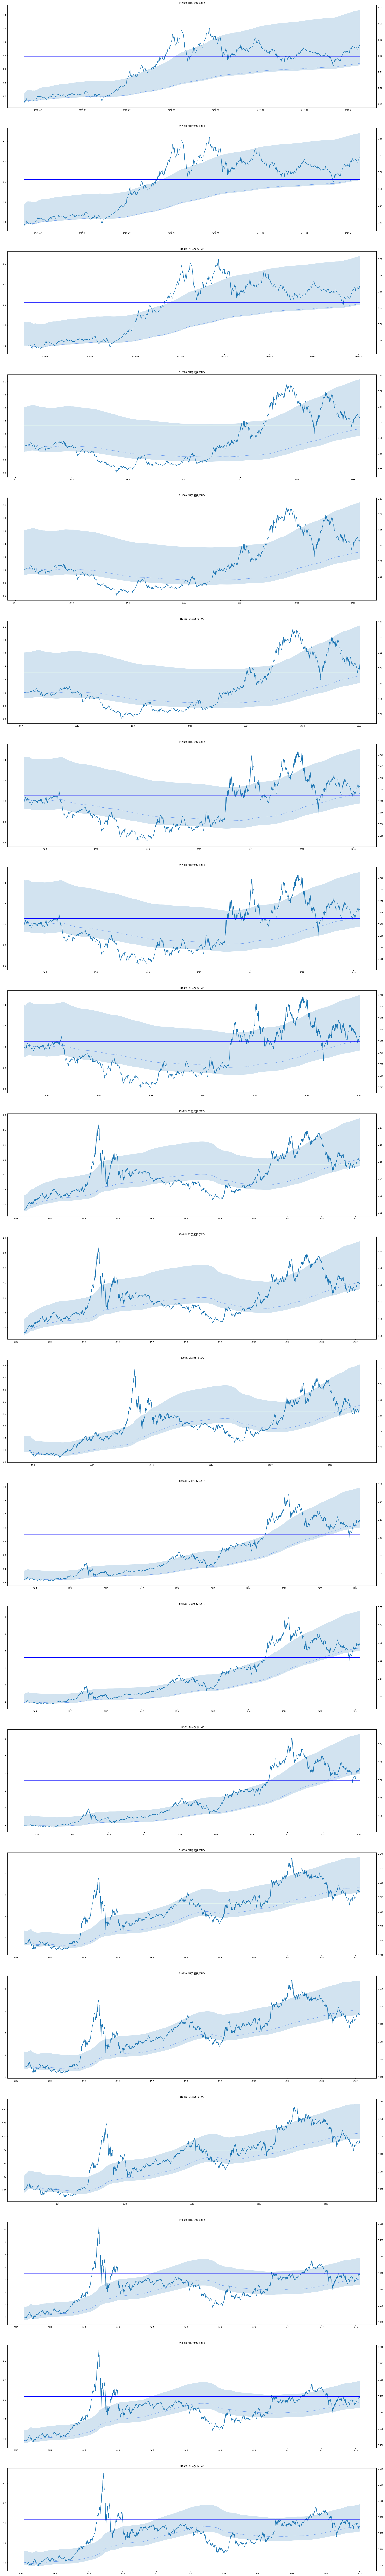

In [71]:
import pandas as pd
stocks = ["512690.SH","512580.SH","512660.SH","159915.SZ","159928.SZ","510330.SH","510500.SH"]

def load_qmt(code,fuquan):
    df = pd.read_csv(f"../data/qmt/{fuquan}/{code}.csv")
    df = df.rename(columns={"Unnamed: 0":"date"})
    df['date'] = df.date.apply(str)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['code'] = code
    return df

def load_ak(code):
    df = pd.read_csv(f"../data/{code[:6]}_{code[:6]}_累计净值走势.csv")
    df = df.rename(columns={"净值日期":"date","累计净值":"close"})
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['code'] = code
    return df

def calc(df):
    df['ma'] = df.close.rolling(window=850,min_periods=1).mean()
    df['diff_percent_close2ma'] = (df.close - df.ma) / df.ma
    p  = df[df.diff_percent_close2ma > 0].diff_percent_close2ma.quantile(0.8)
    n  = df[df.diff_percent_close2ma < 0].diff_percent_close2ma.quantile(1-0.4)
    print("p:",p,"n",n)
    df['ma_upper'] = df.ma * (1 + p)
    df['ma_lower'] = df.ma * (1 + n)
    return df

dfs = []

for s in stocks:
    # 使用qmt数据，前复权
    df = load_qmt(s,'front')
    df = calc(df)
    dfs.append([f'{s}前复权(QMT)',df])

    
    # 使用qmt数据，后复权
    df = load_qmt(s,'back')
    df = calc(df)
    dfs.append([f'{s}后复权(QMT)',df])
    
    
    # 使用ak数据，相当于是后复权
    df = load_ak(s)
    df = calc(df)
    dfs.append([f'{s}后复权(AK)',df])

    
fig = plt.figure(figsize=(30,10*len(dfs)))

import matplotlib.pyplot as plt
for i,data in enumerate(dfs):
    title,df = data
    ax = fig.add_subplot(len(dfs), 1, i+1)
    ax.set_title(title)
    ax.plot(df.date,df.close)
    ax.plot(df.date, df.ma, color='#6495ED', linestyle='--', linewidth=1)
    ax.fill_between(df.date, df.ma_upper, df.ma_lower, alpha=0.2)
    ax2 = ax.twinx()
    #ax2.plot(df.date,df.diff_percent_close2ma,color='r')
    p = df[df.diff_percent_close2ma > 0].diff_percent_close2ma.quantile(0.8)
    ax2.plot(df.date,[p]*len(df.date),color='b')
    